## Data Loading

In [2]:
# Import necessary libraries
import pandas as pd

# Load the datasets
train_df = pd.read_csv('/kaggle/input/hackathon/train.csv')
test_df = pd.read_csv('/kaggle/input/hackathon/test.csv')

# Ensure all text columns are strings
train_df['crimeaditionalinfo'] = train_df['crimeaditionalinfo'].astype(str)
test_df['crimeaditionalinfo'] = test_df['crimeaditionalinfo'].astype(str)

# Display dataset shapes
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

# Preview datasets
train_df.head()


Training data shape: (93686, 3)
Testing data shape: (31229, 3)


,category,sub_category,crimeaditionalinfo
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...


## Exploratory Data Analysis (EDA)

Category Distribution:
category
Online Financial Fraud                                  57434
Online and Social Media Related Crime                   12140
Any Other Cyber Crime                                   10878
Cyber Attack/ Dependent Crimes                           3608
RapeGang Rape RGRSexually Abusive Content                2822
Sexually Obscene material                                1838
Hacking  Damage to computercomputer system etc           1710
Sexually Explicit Act                                    1552
Cryptocurrency Crime                                      480
Online Gambling  Betting                                  444
Child Pornography CPChild Sexual Abuse Material CSAM      379
Online Cyber Trafficking                                  183
Cyber Terrorism                                           161
Ransomware                                                 56
Report Unlawful Content                                     1
Name: count, dtype: int64

Subcategory

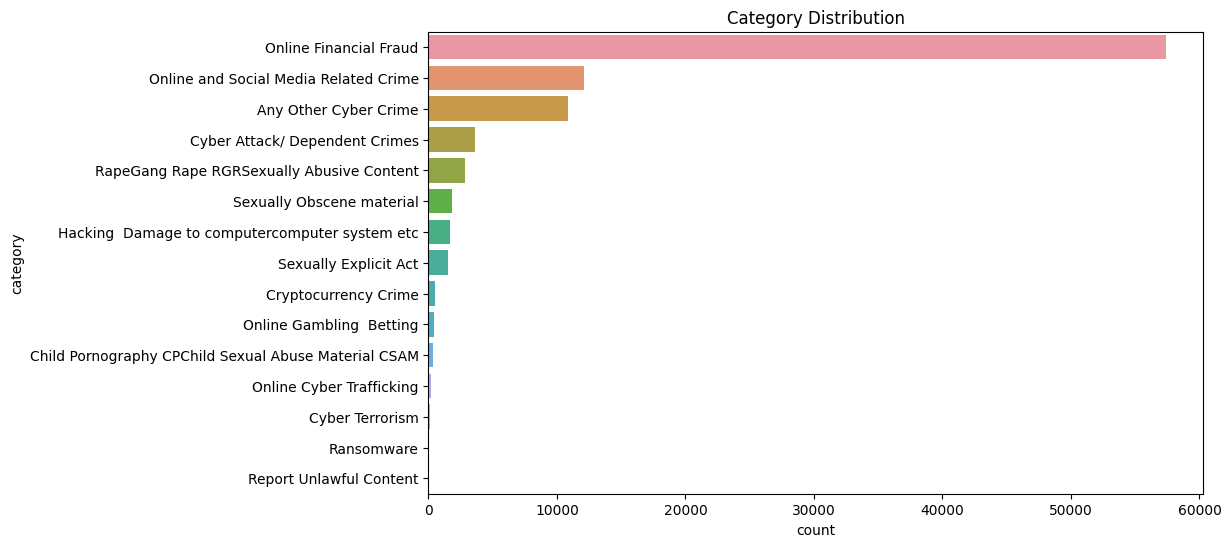

In [3]:
# Check the distribution of categories and subcategories
print("Category Distribution:")
print(train_df['category'].value_counts())
print("\nSubcategory Distribution:")
print(train_df['sub_category'].value_counts())

# Check the average length of descriptions
train_df['text_length'] = train_df['crimeaditionalinfo'].apply(lambda x: len(x.split()))
print("\nAverage description length:", train_df['text_length'].mean())

# Visualize the distribution of categories using a bar plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, y='category', order=train_df['category'].value_counts().index)
plt.title("Category Distribution")
plt.show()


## Text Preprocessing

In [4]:
# Import preprocessing tools
from nltk.stem import PorterStemmer
import re

# Define preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Tokenization
    tokens = text.split()
    # Remove stop words
    stop_words = ['the', 'a', 'an', 'and', 'is', 'are', 'was', 'were', 'in', 'of', 'to', 'for', 'with']
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
train_df['cleaned_text'] = train_df['crimeaditionalinfo'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['crimeaditionalinfo'].apply(preprocess_text)

# Preview cleaned text
train_df[['crimeaditionalinfo', 'cleaned_text']].head()


,crimeaditionalinfo,cleaned_text
0,I had continue received random calls and abusi...,i had continu receiv random call abus messag m...
1,The above fraudster is continuously messaging ...,abov fraudster continu messag me ask me pay hi...
2,He is acting like a police and demanding for m...,he act like polic demand money by ad section t...
3,In apna Job I have applied for job interview f...,apna job i have appli job interview telecal re...
4,I received a call from lady stating that she w...,i receiv call from ladi state that she will se...


## Encode Labels

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoders
category_encoder = LabelEncoder()
sub_category_encoder = LabelEncoder()

# Encode categories and subcategories
train_df['category_encoded'] = category_encoder.fit_transform(train_df['category'])
train_df['sub_category_encoded'] = sub_category_encoder.fit_transform(train_df['sub_category'])

# Handle unseen categories in the test set
def transform_with_fallback(encoder, values):
    known_classes = set(encoder.classes_)
    return [encoder.transform([val])[0] if val in known_classes else -1 for val in values]

test_df['category_encoded'] = transform_with_fallback(category_encoder, test_df['category'])
test_df['sub_category_encoded'] = transform_with_fallback(sub_category_encoder, test_df['sub_category'])

# Check unique encoded values
print("Encoded categories:", train_df['category_encoded'].unique())
print("Encoded subcategories:", train_df['sub_category_encoded'].unique())


Encoded categories: [ 9  7  8 11  0  3  2 13 14  5  4  1  6 10 12]
Encoded subcategories: [ 4 15 21 22 32 18 35 25 26  8 12  7  2 10 14  3 20  1 13 16 33 30 27 29
  5 31  9 24 23 34  6 17 11 28 19  0]


## Tokenization and Padding

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['cleaned_text'])

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
X_test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

# Pad sequences
max_len = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

# Assign labels
y_train = train_df['category_encoded']
y_test = test_df['category_encoded']

print("Padded sequence shape:", X_train_padded.shape)


Padded sequence shape: (93686, 100)


## Build and Compile Model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

# Define model architecture
input_tensor = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=5000, output_dim=256)(input_tensor)
lstm_layer = Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.3))(embedding_layer)
lstm_layer = Dropout(0.4)(lstm_layer)
pooling_layer = GlobalAveragePooling1D()(lstm_layer)
dense_layer = Dense(128, activation='relu')(pooling_layer)
dense_layer = Dropout(0.4)(dense_layer)
output_layer = Dense(len(category_encoder.classes_), activation='softmax')(dense_layer)

model = Model(inputs=input_tensor, outputs=output_layer)

# Compile the model
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Train the Model

In [8]:
# Train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Save the model
model.save('text_classification_model.h5')


Epoch 1/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 296s 247ms/step - accuracy: 0.6957 - loss: 1.0656 - val_accuracy: 0.7492 - val_loss: 0.7641
Epoch 2/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 290s 248ms/step - accuracy: 0.7504 - loss: 0.7770 - val_accuracy: 0.7455 - val_loss: 0.7519
Epoch 3/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 289s 247ms/step - accuracy: 0.7604 - loss: 0.7241 - val_accuracy: 0.7535 - val_loss: 0.7214
Epoch 4/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 321s 246ms/step - accuracy: 0.7662 - loss: 0.6796 - val_accuracy: 0.7590 - val_loss: 0.6974
Epoch 5/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 287s 245ms/step - accuracy: 0.7759 - loss: 0.6507 - val_accuracy: 0.7595 - val_loss: 0.7063
Epoch 6/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 323s 246ms/step - accuracy: 0.7863 - loss: 0.6193 - val_accuracy: 0.7606 - val_loss: 0.7031
Epoch 7/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 289s 246ms/step - accuracy: 0.7920 - loss: 0.5960 - val_accuracy: 0.7580 - val_loss: 0.7205
Epoch 8/10
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 288s 245ms/step - ac

## Evaluate and Predict

In [9]:
from sklearn.metrics import f1_score, recall_score

# Evaluate on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Make predictions
y_pred_probs = model.predict(X_test_padded)
y_pred = y_pred_probs.argmax(axis=1)

# Calculate metrics
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('F1 Score:', f1)
print('Recall Score:', recall)


Test Loss: nan
Test Accuracy: 0.747126042842865
976/976 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step
F1 Score: 0.7179711303731784
Recall Score: 0.7471260687181787


## Visualize Results

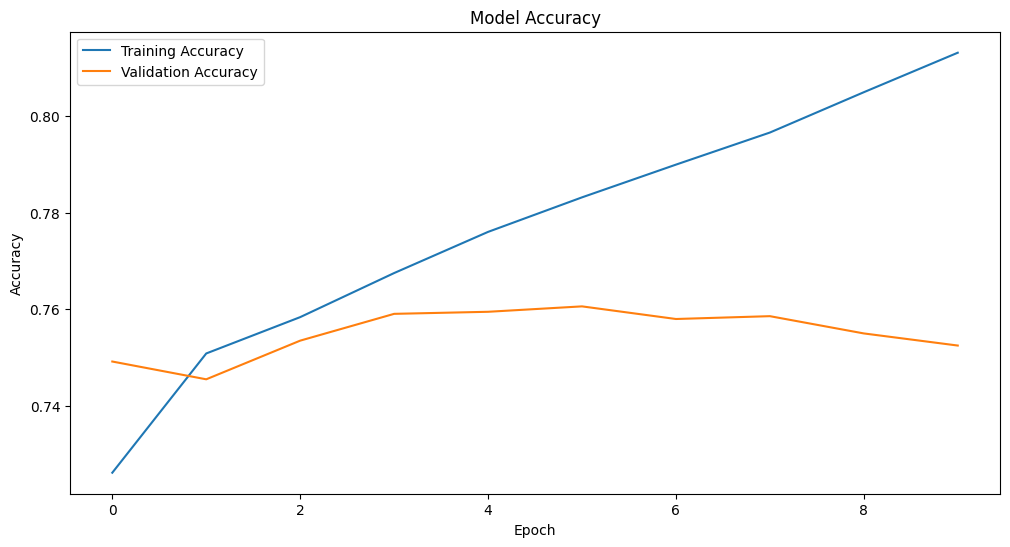

In [10]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
